## Task 4: Explainability through Grad-CAM

In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import matplotlib as mpl

from funcs_Task1 import training_data_Pipeline, test_validation_data_Pipeline
from funcs_Task2_3 import concat_generators

In [2]:
# constants
img_size = (128, 128)

# path to selected test sample
img_path = "covid xray/test/NORMAL/NORMAL-2030.png"


### 1. Grad-CAM implementation

### Now lets try for Resnet model of task 3

In [8]:
def get_img_array(img_path, size):

    img = keras.utils.load_img(img_path, target_size=size)

    array = keras.utils.img_to_array(img)

    # We add a dimension to transform our array into a "batch"
    array = np.expand_dims(array, axis=0)
    return array


In [9]:
preprocess_input = keras.applications.xception.preprocess_input

# Prepare image
img_array = preprocess_input(get_img_array(img_path, size=img_size))
img_array = tf.convert_to_tensor(img_array)

# Make model
model = load_model("ResNet_finetuned_model.keras")

# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
preds = model.predict(img_array)
print("Predicted:", preds)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted: [[1.4046152]]


In [186]:
resnet = model.get_layer("resnet50v2")
names = [i.name for i in resnet.layers]
print(names)
print(names[-117])

['input_layer', 'conv1_pad', 'conv1_conv', 'pool1_pad', 'pool1_pool', 'conv2_block1_preact_bn', 'conv2_block1_preact_relu', 'conv2_block1_1_conv', 'conv2_block1_1_bn', 'conv2_block1_1_relu', 'conv2_block1_2_pad', 'conv2_block1_2_conv', 'conv2_block1_2_bn', 'conv2_block1_2_relu', 'conv2_block1_0_conv', 'conv2_block1_3_conv', 'conv2_block1_out', 'conv2_block2_preact_bn', 'conv2_block2_preact_relu', 'conv2_block2_1_conv', 'conv2_block2_1_bn', 'conv2_block2_1_relu', 'conv2_block2_2_pad', 'conv2_block2_2_conv', 'conv2_block2_2_bn', 'conv2_block2_2_relu', 'conv2_block2_3_conv', 'conv2_block2_out', 'conv2_block3_preact_bn', 'conv2_block3_preact_relu', 'conv2_block3_1_conv', 'conv2_block3_1_bn', 'conv2_block3_1_relu', 'conv2_block3_2_pad', 'conv2_block3_2_conv', 'conv2_block3_2_bn', 'conv2_block3_2_relu', 'max_pooling2d', 'conv2_block3_3_conv', 'conv2_block3_out', 'conv3_block1_preact_bn', 'conv3_block1_preact_relu', 'conv3_block1_1_conv', 'conv3_block1_1_bn', 'conv3_block1_1_relu', 'conv3_blo

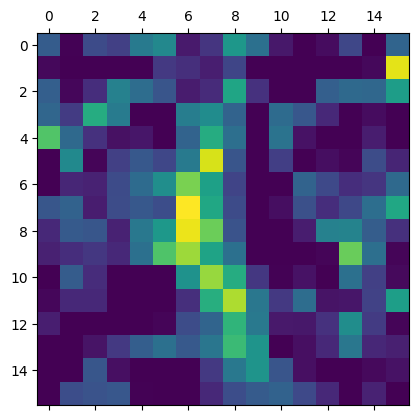

In [195]:

def make_gradcam_heatmap(img_array, model, base_model_name, class_pred = 1):
        
    resnet_model = model.get_layer(base_model_name)
    resnet_names = [i.name for i in resnet.layers]
    model_names = [i.name for i in model.layers]
    target_layer = resnet_model.get_layer(resnet_names[-117]) #-60 is 1 resolutie minder 

    feature_extractor = keras.models.Model(
        inputs=resnet_model.input,
        outputs=[target_layer.output, resnet_model.output]
    )

    # Manually rebuild classifier after ResNet
    classifier_input = keras.Input(shape=resnet_model.output.shape[1:])
    x = classifier_input

    for i in range(len(model.layers)-4, len(model.layers)):
        name = model_names[i]
        # print(name)
        x = model.get_layer(name)(x)

    classifier = keras.models.Model(inputs=classifier_input, outputs=x)

    # Forward and backward passes
    with tf.GradientTape() as tape:
        # Perform forward pass to get both the intermediate activations and the final predictions
        conv_outputs, preds_resnet = feature_extractor(img_array)
        preds = classifier(preds_resnet)
        
        # adapt for binary classification with only one class output
        if class_pred == 1:
            class_channel = preds[:, 0]
        if class_pred == 0:
            class_channel = -preds[:, 0]  # Complement of the scalar output


    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)

    return heatmap.numpy()

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(
    img_array,
    model,
    base_model_name="resnet50v2",
    class_pred= 0
)

plt.matshow(heatmap)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted: [[1.4046152]]
global_average_pooling2d_2
dense_4
dropout_2
dense_5


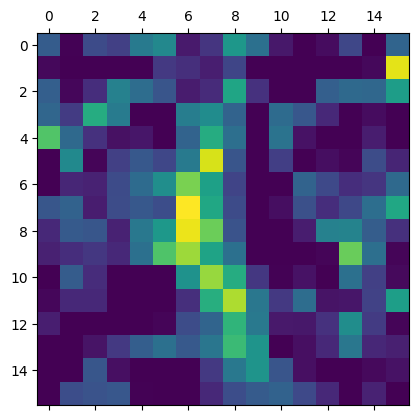

In [189]:
# Prepare image
img_array = preprocess_input(get_img_array(img_path, size=img_size))
img_array = tf.convert_to_tensor(img_array)

# Make model
model = load_model("ResNet_finetuned_model.keras")
# print(model.predict(img_array))

# Remove last layer's sigmoid
model.layers[-1].activation = None

# Print what the top predicted class is
preds = model.predict(img_array)
print("Predicted:", preds)

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(
    img_array,
    model,
    base_model_name="resnet50v2",
     class_pred= 0
)

# Display heatmap
plt.matshow(heatmap)
plt.show()


In [ ]:
import math
1 / (1 + math.exp(-2)) + 1 / (1 + math.exp(2))

0.9999999999999999

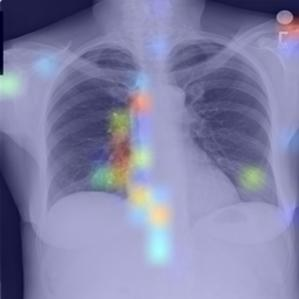

In [190]:
display_gradcam(img_path, heatmap)

# Explaining the decision with Grad-CAM

In [ ]:
def get_gradcam_image(img_path, heatmap, alpha=0.4, threshold=0.8):
    # Load the original image
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)

    heatmap = np.maximum(heatmap, threshold)
    heatmap = (heatmap - threshold) / (heatmap.max() - threshold + 1e-8)  # Normalize after thresholding

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = mpl.colormaps["jet"]

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    return(superimposed_img)


In [158]:
## divide test data into groups
# gather necessary data
test_data_gen = test_validation_data_Pipeline(batch_size, img_size, train_dir, test_dir, shuffle = False)
y_pred_probs = model.predict(test_data_gen)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()
y_true = test_data_gen.classes

filepaths = test_data_gen.filepaths
class_indices = test_data_gen.class_indices

# save filepaths of images in 4 classes, based on right or wrong classification and true value
y_pred_covid = (y_pred == class_indices["COVID"])
y_true_covid = (y_true == class_indices["COVID"])

Covid_misclassified = [filepaths[i] for i in range(len(filepaths)) if y_true_covid[i] & ~y_pred_covid[i]]
Covid_correctclassified = [filepaths[i] for i in range(len(filepaths))  if y_true_covid[i] & y_pred_covid[i]]
normal_misclassified = [filepaths[i] for i in range(len(filepaths))  if ~y_true_covid[i] & y_pred_covid[i]]
normal_correctclassified = [filepaths[i] for i in range(len(filepaths))  if ~y_true_covid[i] & ~y_pred_covid[i]]


Found 1600 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


c:\Users\friev\OneDrive - UGent\MaStat\Big Data Science\Artificial Intelligence\exercises\project\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 3s/step


In [159]:
# sanity check classes
len(Covid_misclassified)+len(Covid_correctclassified)+len(normal_correctclassified)+len(normal_misclassified)

200

In [198]:
# function plotting some images with grad-cam
def show_some_gradcams_from_list(list, img_size, model, class_pred, start_index = 0, stop_index = 5 ):
    plt.figure(figsize=(15, 6))
    for i, img_path in enumerate(list[start_index:stop_index]):
        # make gradcam image
        img_array = preprocess_input(get_img_array(img_path, size=img_size))
        heatmap = make_gradcam_heatmap(img_array, model, base_model_name="resnet50v2", class_pred=class_pred)
        img = get_gradcam_image(img_path, heatmap, threshold = 0.5)

        # plot gradcam image
        plt.subplot(2, 5, i+1)
        plt.imshow(img)
        plt.axis('off')
        
    plt.tight_layout()
    plt.show()

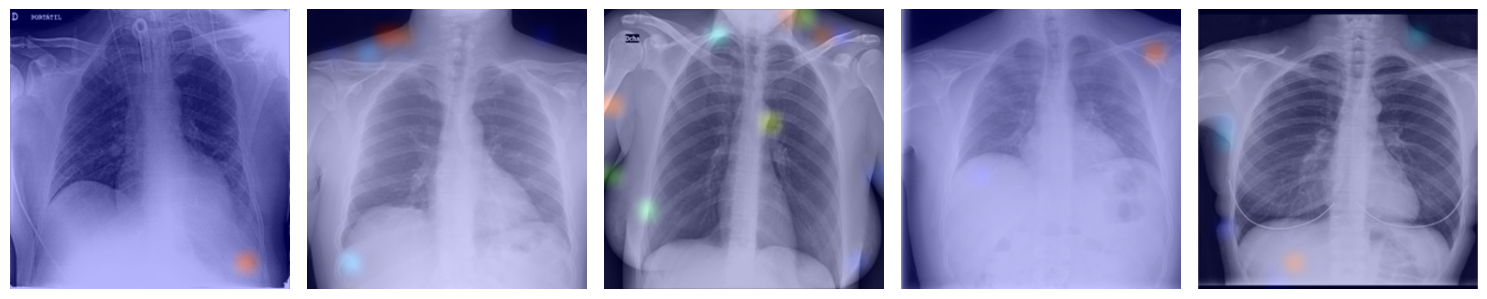

In [199]:
#Covid cases that are misclassified by the model as normal
show_some_gradcams_from_list(Covid_misclassified, img_size, model, start_index = 20, stop_index = 25, class_pred= class_indices["NORMAL"])

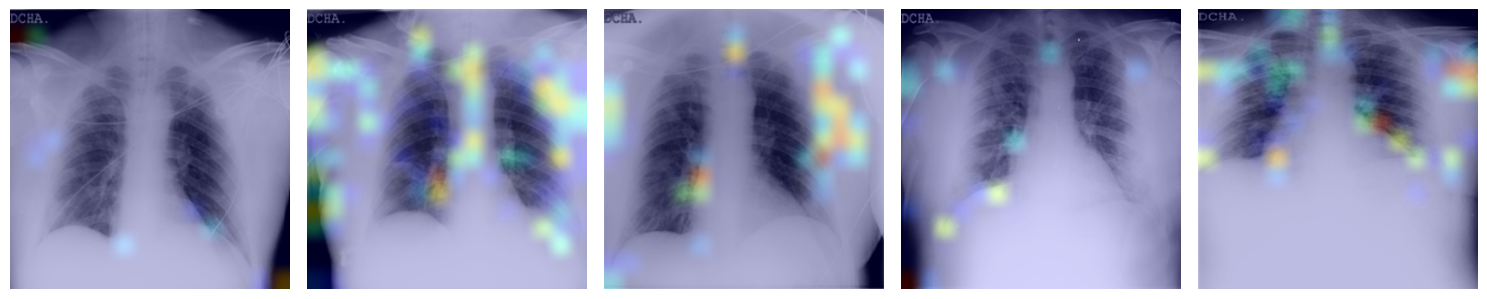

In [200]:
#Covid cases that are correctly classified by the model 
show_some_gradcams_from_list(Covid_correctclassified, img_size, model, start_index = 0, stop_index = 5, class_pred= class_indices["COVID"])

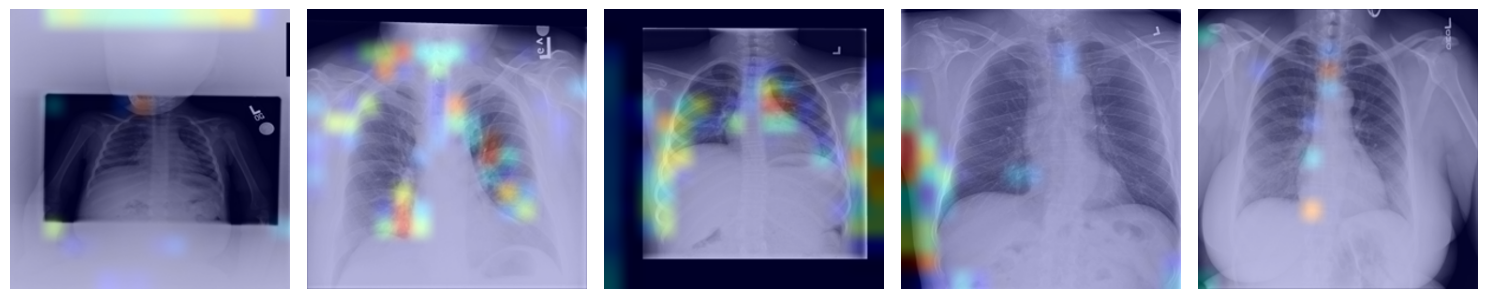

In [201]:
#normal cases that are incorrectly classified by the model as covid cases
show_some_gradcams_from_list(normal_misclassified, img_size, model, start_index = 0, stop_index = 5, class_pred=  class_indices["COVID"])


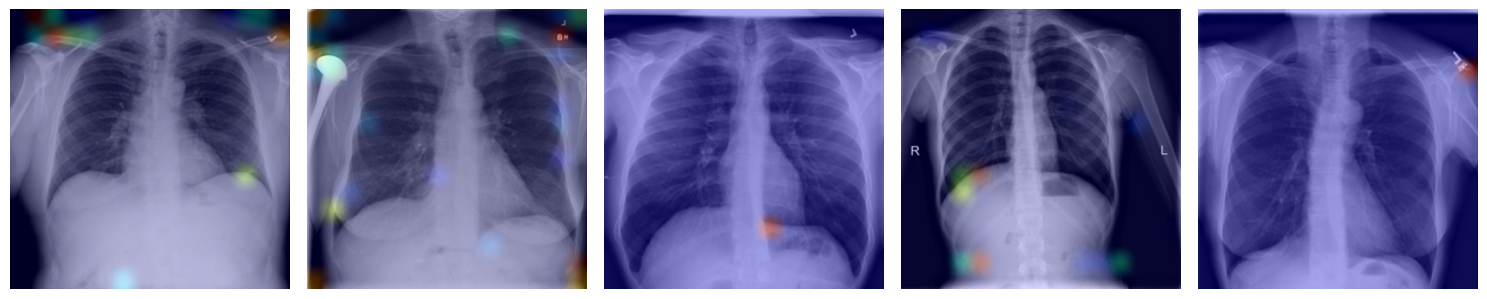

In [202]:
#normal cases that are correctly classified by the model
show_some_gradcams_from_list(normal_correctclassified, img_size, model, start_index = 0, stop_index = 5, class_pred=  class_indices["NORMAL"] )